In [158]:
from collections.abc import Sequence
from sklearn import preprocessing
import numpy as np
import pandas as pd
import datetime
import shutil
import os
import keras_tuner as kt
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)    
    




The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Data Preprocessing

In [159]:
import io
import requests
path = "./data/"

filename_read = os.path.join(path,"heart_disease.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# dropping any row with missing values
df.dropna(inplace = True)

# Check and Drop Duplicate rows
df.drop_duplicates(inplace = True)


#Encoding categorical values using one-hot encoding
encode_text_dummy(df, 'sex')
encode_text_dummy(df, 'chest pain type')
encode_text_dummy(df, 'fasting blood sugar')
encode_text_dummy(df, 'resting ecg')
encode_text_dummy(df, 'exercise angina')
encode_text_dummy(df, 'ST slope')

#Normalizing the columns
encode_numeric_zscore(df,'age')
encode_numeric_zscore(df,'resting bp s')
encode_numeric_zscore(df,'cholesterol')
encode_numeric_zscore(df,'max heart rate')
encode_numeric_zscore(df,'oldpeak')

target = encode_text_index(df,'target')

df


,age,resting bp s,cholesterol,max heart rate,oldpeak,target,sex-0,sex-1,chest pain type-1,chest pain type-2,...,fasting blood sugar-1,resting ecg-0,resting ecg-1,resting ecg-2,exercise angina-0,exercise angina-1,ST slope-0,ST slope-1,ST slope-2,ST slope-3
0,-1.432359,0.410685,0.824621,1.382175,-0.831979,0,False,True,False,True,...,False,True,False,False,True,False,False,True,False,False
1,-0.478223,1.490940,-0.171867,0.753746,0.105606,1,True,False,False,False,...,False,True,False,False,True,False,False,False,True,False
2,-1.750404,-0.129442,0.769768,-1.524307,-0.831979,0,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
3,-0.584238,0.302660,0.138964,-1.131539,0.574398,1,True,False,False,False,...,False,True,False,False,False,True,False,False,True,False
4,0.051853,0.950812,-0.034736,-0.581664,-0.831979,0,False,True,False,False,...,False,True,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,-0.902283,-1.209697,0.596068,-0.188897,0.293123,1,False,True,True,False,...,False,True,False,False,True,False,False,False,True,False
1186,1.536064,0.626736,-0.053020,0.164595,2.355810,1,False,True,False,False,...,True,True,False,False,True,False,False,False,True,False
1187,0.369898,-0.129442,-0.619830,-0.856602,0.293123,1,False,True,False,False,...,False,True,False,False,False,True,False,False,True,False
1188,0.369898,-0.129442,0.340090,1.460728,-0.831979,1,True,False,False,True,...,False,False,False,True,True,False,False,False,True,False


In [160]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



# Create x & y for training and testing
x, y = to_xy(df,'target')



In [161]:
x.shape

(918, 22)

In [162]:
y.shape

(918, 2)

In [163]:
x

array([[-1.432359  ,  0.41068503,  0.8246208 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.4782229 ,  1.4909396 , -0.17186736, ...,  0.        ,
         1.        ,  0.        ],
       [-1.7504044 , -0.12944227,  0.7697682 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.36989808, -0.12944227, -0.6198299 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.36989808, -0.12944227,  0.34008983, ...,  0.        ,
         1.        ,  0.        ],
       [-1.6443893 ,  0.30265957, -0.21757783, ...,  1.        ,
         0.        ,  0.        ]], dtype=float32)

In [164]:
y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [165]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 

In [166]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'] )
    
    #tensorboard logs
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    train_history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer,tensorboard_callback],verbose=2,epochs=1000)



print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)

print(pred)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

#test loss
print("Average test loss: ", np.average(train_history.history['loss']))

0
Epoch 1/1000
22/22 - 0s - loss: 0.7429 - accuracy: 0.4651 - val_loss: 0.6956 - val_accuracy: 0.5043 - 298ms/epoch - 14ms/step
Epoch 2/1000
22/22 - 0s - loss: 0.6777 - accuracy: 0.5247 - val_loss: 0.6563 - val_accuracy: 0.6000 - 46ms/epoch - 2ms/step
Epoch 3/1000
22/22 - 0s - loss: 0.6350 - accuracy: 0.6526 - val_loss: 0.6151 - val_accuracy: 0.7217 - 45ms/epoch - 2ms/step
Epoch 4/1000
22/22 - 0s - loss: 0.5859 - accuracy: 0.7762 - val_loss: 0.5584 - val_accuracy: 0.8043 - 44ms/epoch - 2ms/step
Epoch 5/1000
22/22 - 0s - loss: 0.5248 - accuracy: 0.8212 - val_loss: 0.4891 - val_accuracy: 0.8391 - 46ms/epoch - 2ms/step
Epoch 6/1000
22/22 - 0s - loss: 0.4524 - accuracy: 0.8561 - val_loss: 0.4293 - val_accuracy: 0.8696 - 46ms/epoch - 2ms/step
Epoch 7/1000
22/22 - 0s - loss: 0.3936 - accuracy: 0.8692 - val_loss: 0.3856 - val_accuracy: 0.8696 - 50ms/epoch - 2ms/step
Epoch 8/1000
22/22 - 0s - loss: 0.3652 - accuracy: 0.8706 - val_loss: 0.3701 - val_accuracy: 0.8565 - 47ms/epoch - 2ms/step
Epoc

In [167]:
#%tensorboard --logdir logs 
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 95423), started 0:32:02 ago. (Use '!kill 95423' to kill it.)

In [168]:
score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

score = metrics.roc_auc_score(y_true, pred, average= "weighted")
print("ROC_AUC score: {}".format(score))

Final accuracy: 0.8913043478260869
Precision score: 0.8920001201333481
Recall score: 0.8913043478260869
F1 score: 0.8914989741310249
ROC_AUC score: 0.8908472479901052


In [169]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

[[ 87  11]
 [ 14 118]]
Plotting confusion matrix


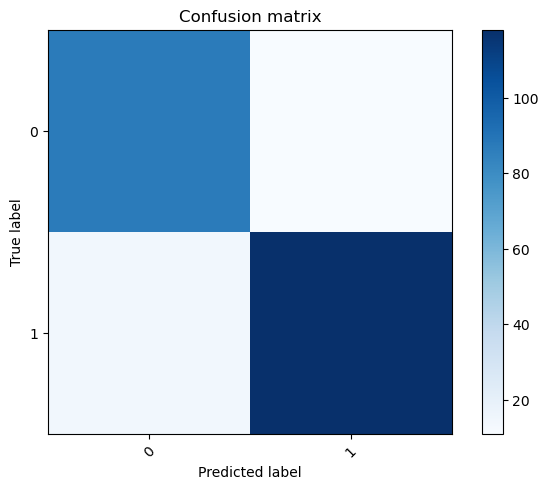

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        98
           1       0.91      0.89      0.90       132

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



In [170]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, target)
plt.show()

print(classification_report(y_true, pred))

8/8 [==============================] - 0s 2ms/step


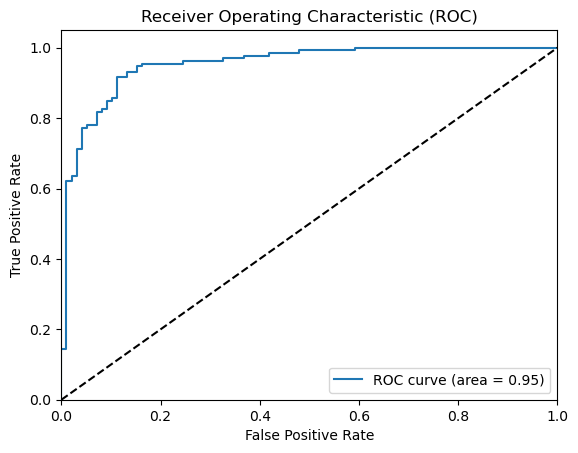

In [171]:
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

Hyper Parameter Tuning using keras tuner with Activiation - Relu and Optimizer - Adam

In [172]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [173]:
def model_builder(hp):
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.Input(shape=(x.shape[1],)))
  #model.add(tf.keras.layers.Flatten()) 
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

In [174]:

tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_accuracy",
    max_trials=2,
    executions_per_trial=1,
    directory="my_dir",
    overwrite=True,
)
    
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tuner.search(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])
best_hps = tuner.get_best_hyperparameters(5)[0]        # num_trials: Optional number of HyperParameters objects to return.

# Build the model with the optimal hyperparameters and train it on the data for 2 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])

print(f"Optimal number of neuron in the Dense layer: {best_hps.get('units')}")
print (f"Optimal learning rate: {best_hps.get('learning_rate')}")



Trial 2 Complete [00h 00m 01s]
val_accuracy: 0.873913049697876

Best val_accuracy So Far: 0.873913049697876
Total elapsed time: 00h 00m 05s
Epoch 1/1000
22/22 - 0s - loss: 0.7525 - accuracy: 0.4898 - val_loss: 0.7439 - val_accuracy: 0.4565 - 199ms/epoch - 9ms/step
Epoch 2/1000
22/22 - 0s - loss: 0.7186 - accuracy: 0.5029 - val_loss: 0.7136 - val_accuracy: 0.4913 - 32ms/epoch - 1ms/step
Epoch 3/1000
22/22 - 0s - loss: 0.6879 - accuracy: 0.5378 - val_loss: 0.6853 - val_accuracy: 0.5174 - 32ms/epoch - 1ms/step
Epoch 4/1000
22/22 - 0s - loss: 0.6591 - accuracy: 0.5683 - val_loss: 0.6599 - val_accuracy: 0.5522 - 32ms/epoch - 1ms/step
Epoch 5/1000
22/22 - 0s - loss: 0.6338 - accuracy: 0.6163 - val_loss: 0.6359 - val_accuracy: 0.6043 - 33ms/epoch - 2ms/step
Epoch 6/1000
22/22 - 0s - loss: 0.6100 - accuracy: 0.6642 - val_loss: 0.6148 - val_accuracy: 0.6609 - 32ms/epoch - 1ms/step
Epoch 7/1000
22/22 - 0s - loss: 0.5884 - accuracy: 0.7122 - val_loss: 0.5950 - val_accuracy: 0.7174 - 32ms/epoch - 

In [175]:
%tensorboard --logdir logs 

Reusing TensorBoard on port 6006 (pid 95423), started 0:32:12 ago. (Use '!kill 95423' to kill it.)

In [176]:
eval_result = model.evaluate(x_test, y_test)
print("[val loss, val accuracy]:", eval_result)

8/8 [==============================] - 0s 636us/step - loss: 0.3088 - accuracy: 0.8739
[val loss, val accuracy]: [0.3087790906429291, 0.873913049697876]


In [177]:
 #Measure accuracy
pred = model.predict(x_test)

print(pred)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

score = metrics.roc_auc_score(y_true, pred, average= "weighted")
print("ROC_AUC score: {}".format(score))

print(classification_report(y_true, pred))

8/8 [==============================] - 0s 410us/step
[[0.972531   0.027469  ]
 [0.6960792  0.30392075]
 [0.02659411 0.97340596]
 [0.03107127 0.96892875]
 [0.9652102  0.03478983]
 [0.12756376 0.8724362 ]
 [0.07708199 0.9229181 ]
 [0.8649742  0.13502584]
 [0.25346497 0.746535  ]
 [0.12220544 0.87779456]
 [0.25414103 0.74585897]
 [0.8540437  0.14595625]
 [0.397585   0.6024151 ]
 [0.91552585 0.08447421]
 [0.0793311  0.92066884]
 [0.1179634  0.88203657]
 [0.972063   0.02793704]
 [0.04115125 0.9588487 ]
 [0.17520034 0.8247997 ]
 [0.8202738  0.17972618]
 [0.15939856 0.84060144]
 [0.1532803  0.84671974]
 [0.97590035 0.02409966]
 [0.3464954  0.6535046 ]
 [0.16068827 0.8393118 ]
 [0.09334467 0.9066553 ]
 [0.97333264 0.02666733]
 [0.24525012 0.7547499 ]
 [0.9476818  0.05231818]
 [0.9652983  0.03470174]
 [0.1947298  0.80527025]
 [0.8505488  0.14945124]
 [0.43998152 0.56001854]
 [0.05341489 0.9465851 ]
 [0.04704358 0.9529564 ]
 [0.5819994  0.41800058]
 [0.05131382 0.94868624]
 [0.96775895 0.0322410

[[ 86  12]
 [ 17 115]]
Plotting confusion matrix


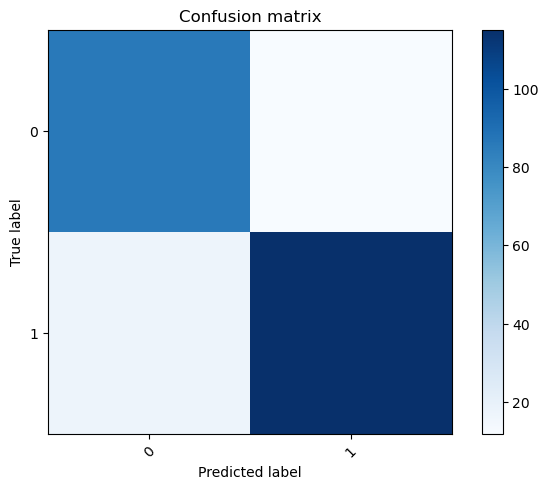

              precision    recall  f1-score   support

           0       0.83      0.88      0.86        98
           1       0.91      0.87      0.89       132

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.88      0.87      0.87       230

8/8 [==============================] - 0s 1ms/step


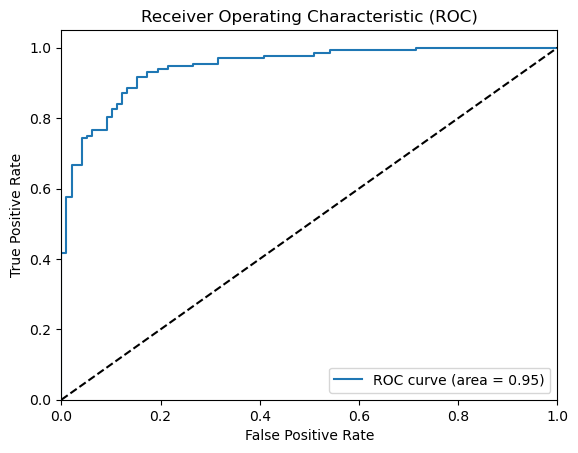

In [178]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, target)
plt.show()

print(classification_report(y_true, pred))

#ROC curve
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

Hyper Parameter Tuning using keras tuner with Activiation - tanh and Optimizer - SGD

In [179]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [180]:
def model_builder(hp):
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.Input(shape=(x.shape[1],)))
  #model.add(tf.keras.layers.Flatten()) 
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='tanh'))
  model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.9, nesterov=True),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model


tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_accuracy",
    max_trials=2,
    executions_per_trial=1,
    directory="my_dir",
    overwrite=True,
)
    
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tuner.search(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])
best_hps = tuner.get_best_hyperparameters(5)[0]        # num_trials: Optional number of HyperParameters objects to return.

# Build the model with the optimal hyperparameters and train it on the data for 2 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])

print(f"Optimal number of neuron in the Dense layer: {best_hps.get('units')}")
print (f"Optimal learning rate: {best_hps.get('learning_rate')}")


Trial 2 Complete [00h 00m 11s]
val_accuracy: 0.8608695864677429

Best val_accuracy So Far: 0.8695651888847351
Total elapsed time: 00h 00m 22s


Epoch 1/1000
22/22 - 0s - loss: 0.7685 - accuracy: 0.4084 - val_loss: 0.7420 - val_accuracy: 0.4783 - 198ms/epoch - 9ms/step
Epoch 2/1000
22/22 - 0s - loss: 0.7300 - accuracy: 0.4782 - val_loss: 0.7047 - val_accuracy: 0.5261 - 31ms/epoch - 1ms/step
Epoch 3/1000
22/22 - 0s - loss: 0.6915 - accuracy: 0.5596 - val_loss: 0.6704 - val_accuracy: 0.5957 - 30ms/epoch - 1ms/step
Epoch 4/1000
22/22 - 0s - loss: 0.6571 - accuracy: 0.6366 - val_loss: 0.6415 - val_accuracy: 0.6783 - 32ms/epoch - 1ms/step
Epoch 5/1000
22/22 - 0s - loss: 0.6274 - accuracy: 0.7020 - val_loss: 0.6169 - val_accuracy: 0.7261 - 31ms/epoch - 1ms/step
Epoch 6/1000
22/22 - 0s - loss: 0.6021 - accuracy: 0.7456 - val_loss: 0.5951 - val_accuracy: 0.7870 - 31ms/epoch - 1ms/step
Epoch 7/1000
22/22 - 0s - loss: 0.5802 - accuracy: 0.7791 - val_loss: 0.5753 - val_accuracy: 0.8000 - 30ms/epoch - 1ms/step
Epoch 8/1000
22/22 - 0s - loss: 0.5605 - accuracy: 0.7980 - val_loss: 0.5585 - val_accuracy: 0.8087 - 30ms/epoch - 1ms/step
Epoch 9

In [181]:
%tensorboard --logdir logs 

Reusing TensorBoard on port 6006 (pid 95423), started 0:32:44 ago. (Use '!kill 95423' to kill it.)

In [182]:
#Measure accuracy
pred = model.predict(x_test)

print(pred)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

score = metrics.roc_auc_score(y_true, pred, average= "weighted")
print("ROC_AUC score: {}".format(score))

print(classification_report(y_true, pred))

8/8 [==============================] - 0s 385us/step
[[0.9707489  0.02925108]
 [0.8182239  0.18177614]
 [0.0376096  0.9623904 ]
 [0.02579047 0.9742095 ]
 [0.9561255  0.0438745 ]
 [0.17401011 0.8259899 ]
 [0.15696593 0.8430341 ]
 [0.8989934  0.1010066 ]
 [0.24633634 0.75366366]
 [0.05697517 0.9430249 ]
 [0.27042657 0.7295735 ]
 [0.8737073  0.12629266]
 [0.3426293  0.65737075]
 [0.92562604 0.07437403]
 [0.10921372 0.89078623]
 [0.30445367 0.6955463 ]
 [0.9726499  0.02735017]
 [0.17278789 0.8272121 ]
 [0.24455567 0.75544435]
 [0.8483782  0.15162185]
 [0.2150961  0.7849038 ]
 [0.19711705 0.80288297]
 [0.9586593  0.04134069]
 [0.26114365 0.7388564 ]
 [0.15977186 0.8402282 ]
 [0.10533769 0.8946623 ]
 [0.95144033 0.04855965]
 [0.16290292 0.83709705]
 [0.9454191  0.05458092]
 [0.95873934 0.04126069]
 [0.29706755 0.7029324 ]
 [0.8573056  0.14269447]
 [0.28754526 0.71245474]
 [0.06458735 0.9354127 ]
 [0.08537199 0.914628  ]
 [0.6106768  0.38932317]
 [0.06153145 0.9384685 ]
 [0.95249367 0.0475063

[[ 87  11]
 [ 19 113]]
Plotting confusion matrix


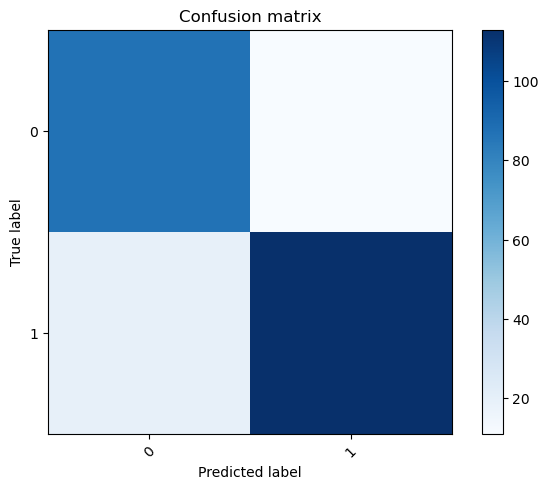

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        98
           1       0.91      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230

8/8 [==============================] - 0s 1ms/step


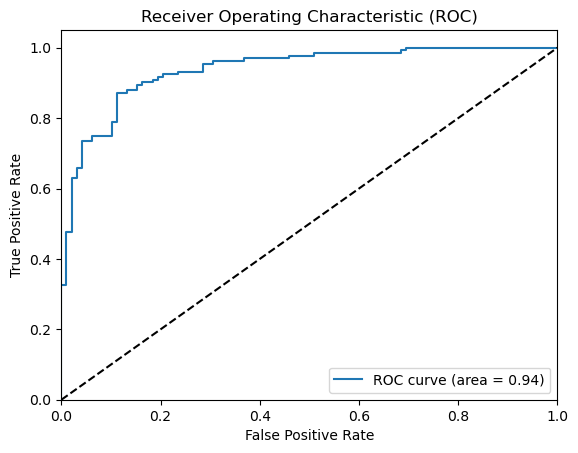

In [183]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, target)
plt.show()

print(classification_report(y_true, pred))

#ROC curve
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

Hyper Parameter Tuning using keras tuner with Activiation - Relu and Optimizer - SGD

In [184]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

def model_builder(hp):
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.Input(shape=(x.shape[1],)))
  #model.add(tf.keras.layers.Flatten()) 
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.9, nesterov=True),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model


tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_accuracy",
    max_trials=2,
    executions_per_trial=1,
    directory="my_dir",
    overwrite=True,
)
    
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tuner.search(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])
best_hps = tuner.get_best_hyperparameters(5)[0]        # num_trials: Optional number of HyperParameters objects to return.

# Build the model with the optimal hyperparameters and train it on the data for 2 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])

print(f"Optimal number of neuron in the Dense layer: {best_hps.get('units')}")
print (f"Optimal learning rate: {best_hps.get('learning_rate')}")


Trial 2 Complete [00h 00m 01s]
val_accuracy: 0.873913049697876

Best val_accuracy So Far: 0.8782608509063721
Total elapsed time: 00h 00m 02s
Epoch 1/1000
22/22 - 0s - loss: 0.5203 - accuracy: 0.7544 - val_loss: 0.3971 - val_accuracy: 0.8391 - 204ms/epoch - 9ms/step
Epoch 2/1000
22/22 - 0s - loss: 0.3618 - accuracy: 0.8561 - val_loss: 0.3475 - val_accuracy: 0.8522 - 33ms/epoch - 2ms/step
Epoch 3/1000
22/22 - 0s - loss: 0.3381 - accuracy: 0.8648 - val_loss: 0.3397 - val_accuracy: 0.8565 - 33ms/epoch - 1ms/step
Epoch 4/1000
22/22 - 0s - loss: 0.3270 - accuracy: 0.8677 - val_loss: 0.3320 - val_accuracy: 0.8696 - 32ms/epoch - 1ms/step
Epoch 5/1000
22/22 - 0s - loss: 0.3229 - accuracy: 0.8663 - val_loss: 0.3179 - val_accuracy: 0.8739 - 32ms/epoch - 1ms/step
Epoch 6/1000
22/22 - 0s - loss: 0.3162 - accuracy: 0.8765 - val_loss: 0.3234 - val_accuracy: 0.8565 - 31ms/epoch - 1ms/step
Epoch 7/1000
22/22 - 0s - loss: 0.3121 - accuracy: 0.8750 - val_loss: 0.3144 - val_accuracy: 0.8739 - 31ms/epoch -

In [185]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 95423), started 0:32:48 ago. (Use '!kill 95423' to kill it.)

In [186]:
#Measure accuracy
pred = model.predict(x_test)

print(pred)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

score = metrics.roc_auc_score(y_true, pred, average= "weighted")
print("ROC_AUC score: {}".format(score))

print(classification_report(y_true, pred))

8/8 [==============================] - 0s 646us/step
[[9.74677861e-01 2.53220890e-02]
 [3.45535696e-01 6.54464304e-01]
 [3.36241126e-02 9.66375947e-01]
 [1.90256573e-02 9.80974376e-01]
 [9.48633194e-01 5.13668135e-02]
 [1.12532891e-01 8.87467086e-01]
 [6.42135814e-02 9.35786366e-01]
 [8.20340812e-01 1.79659188e-01]
 [3.53066415e-01 6.46933615e-01]
 [7.66654387e-02 9.23334539e-01]
 [4.92885530e-01 5.07114470e-01]
 [9.66250837e-01 3.37491781e-02]
 [4.12947416e-01 5.87052584e-01]
 [8.16233516e-01 1.83766514e-01]
 [4.64934893e-02 9.53506529e-01]
 [1.16318524e-01 8.83681476e-01]
 [9.82556880e-01 1.74431056e-02]
 [1.98222958e-02 9.80177701e-01]
 [9.70530361e-02 9.02947009e-01]
 [4.10263509e-01 5.89736521e-01]
 [3.09400231e-01 6.90599740e-01]
 [1.38031065e-01 8.61968994e-01]
 [9.82255816e-01 1.77441426e-02]
 [6.11360908e-01 3.88639092e-01]
 [1.31563067e-01 8.68436992e-01]
 [1.05476990e-01 8.94523025e-01]
 [9.79853392e-01 2.01466568e-02]
 [3.70878845e-01 6.29121184e-01]
 [9.55055833e-01 4.4944

[[ 86  12]
 [ 14 118]]
Plotting confusion matrix


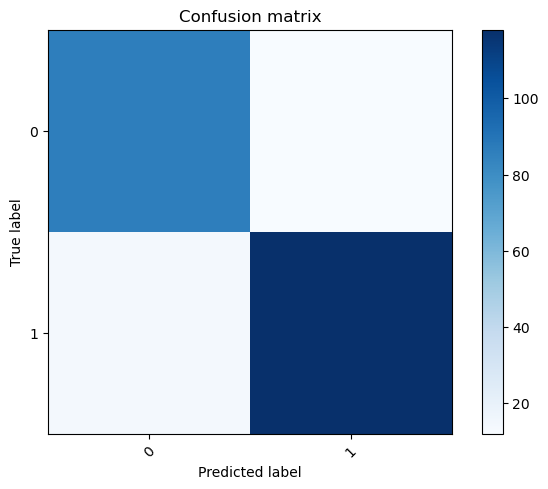

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        98
           1       0.91      0.89      0.90       132

    accuracy                           0.89       230
   macro avg       0.88      0.89      0.88       230
weighted avg       0.89      0.89      0.89       230

8/8 [==============================] - 0s 3ms/step


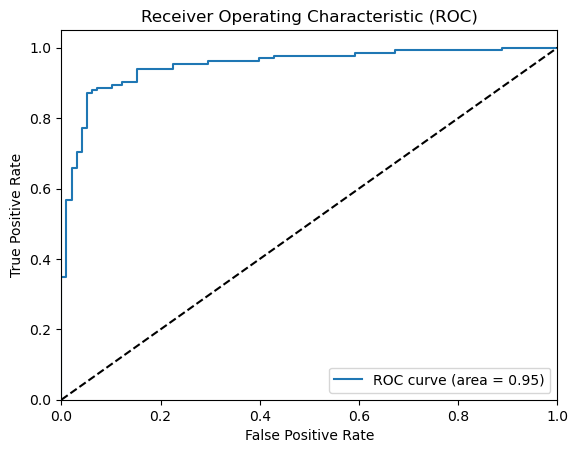

In [187]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, target)
plt.show()

print(classification_report(y_true, pred))

#ROC curve
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

Hyper Parameter Tuning using keras tuner with Activiation - tanh and Optimizer - ADAM

In [188]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

def model_builder(hp):
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.Input(shape=(x.shape[1],)))
  #model.add(tf.keras.layers.Flatten()) 
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.9, nesterov=True),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model


tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_accuracy",
    max_trials=2,
    executions_per_trial=1,
    directory="my_dir",
    overwrite=True,
)
    
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tuner.search(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])
best_hps = tuner.get_best_hyperparameters(5)[0]        # num_trials: Optional number of HyperParameters objects to return.

# Build the model with the optimal hyperparameters and train it on the data for 2 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])

print(f"Optimal number of neuron in the Dense layer: {best_hps.get('units')}")
print (f"Optimal learning rate: {best_hps.get('learning_rate')}")


Trial 2 Complete [00h 00m 01s]
val_accuracy: 0.8826087117195129

Best val_accuracy So Far: 0.8826087117195129
Total elapsed time: 00h 00m 02s
Epoch 1/1000
22/22 - 0s - loss: 0.5538 - accuracy: 0.7122 - val_loss: 0.3939 - val_accuracy: 0.8478 - 198ms/epoch - 9ms/step
Epoch 2/1000
22/22 - 0s - loss: 0.3674 - accuracy: 0.8488 - val_loss: 0.3538 - val_accuracy: 0.8609 - 32ms/epoch - 1ms/step
Epoch 3/1000
22/22 - 0s - loss: 0.3414 - accuracy: 0.8576 - val_loss: 0.3325 - val_accuracy: 0.8696 - 33ms/epoch - 1ms/step
Epoch 4/1000
22/22 - 0s - loss: 0.3275 - accuracy: 0.8779 - val_loss: 0.3149 - val_accuracy: 0.8826 - 35ms/epoch - 2ms/step
Epoch 5/1000
22/22 - 0s - loss: 0.3186 - accuracy: 0.8750 - val_loss: 0.3309 - val_accuracy: 0.8696 - 33ms/epoch - 1ms/step
Epoch 6/1000
22/22 - 0s - loss: 0.3159 - accuracy: 0.8794 - val_loss: 0.3031 - val_accuracy: 0.8826 - 30ms/epoch - 1ms/step
Epoch 7/1000
22/22 - 0s - loss: 0.3114 - accuracy: 0.8808 - val_loss: 0.3213 - val_accuracy: 0.8696 - 31ms/epoch 

In [189]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 95423), started 0:32:52 ago. (Use '!kill 95423' to kill it.)

In [190]:
#Measure accuracy
pred = model.predict(x_test)

print(pred)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

score = metrics.roc_auc_score(y_true, pred, average= "weighted")
print("ROC_AUC score: {}".format(score))

print(classification_report(y_true, pred))

8/8 [==============================] - 0s 360us/step
[[0.97948396 0.02051603]
 [0.47024685 0.52975315]
 [0.03262165 0.9673784 ]
 [0.02322247 0.9767775 ]
 [0.9626807  0.03731932]
 [0.18935281 0.8106472 ]
 [0.0853508  0.9146492 ]
 [0.8581542  0.14184579]
 [0.30534896 0.694651  ]
 [0.08773513 0.91226494]
 [0.40458268 0.5954173 ]
 [0.9522638  0.04773614]
 [0.41185707 0.5881429 ]
 [0.92294914 0.07705083]
 [0.07433187 0.9256681 ]
 [0.12458754 0.8754124 ]
 [0.9775214  0.02247853]
 [0.05483494 0.94516504]
 [0.13675678 0.8632433 ]
 [0.54585236 0.45414758]
 [0.29349262 0.7065074 ]
 [0.19245628 0.8075437 ]
 [0.9856154  0.01438466]
 [0.5591209  0.4408791 ]
 [0.15578428 0.84421563]
 [0.12360467 0.87639534]
 [0.9803817  0.0196183 ]
 [0.32086763 0.6791324 ]
 [0.954289   0.045711  ]
 [0.9776584  0.02234164]
 [0.15226902 0.84773093]
 [0.92627597 0.07372399]
 [0.56014895 0.4398511 ]
 [0.0429386  0.9570614 ]
 [0.06423184 0.9357682 ]
 [0.59857994 0.40142006]
 [0.04878086 0.9512192 ]
 [0.97427535 0.0257246

[[ 87  11]
 [ 17 115]]
Plotting confusion matrix


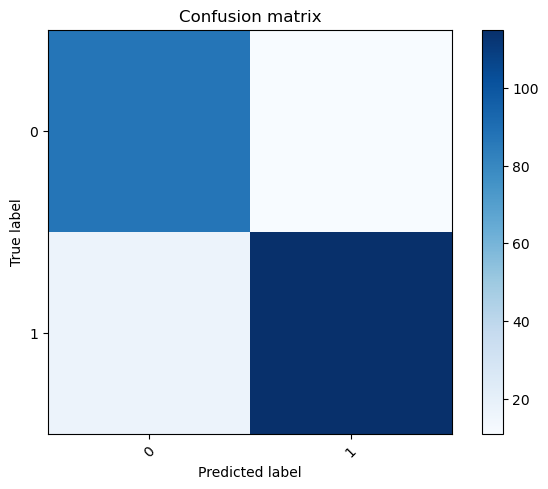

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        98
           1       0.91      0.87      0.89       132

    accuracy                           0.88       230
   macro avg       0.87      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230

8/8 [==============================] - 0s 1ms/step


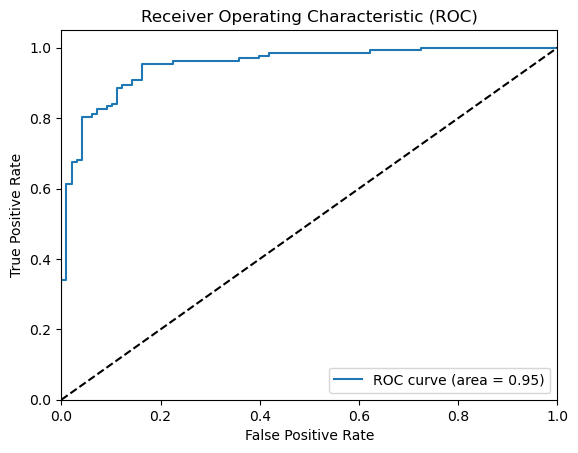

In [191]:
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, target)
plt.show()

print(classification_report(y_true, pred))

#ROC curve
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)